# Контекст

- бинарная классификации изображений


In [5]:
# база
import pandas as pd
import numpy as np
import os
import warnings
import time
import copy

# визуализация
import matplotlib.pyplot as plt
from PIL import Image,\
                ImageDraw
import seaborn as sns

# torch
import torch
from torch.utils.data import Dataset,\
                             DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchsummary import summary

# sklearn
from sklearn.model_selection import train_test_split


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
warnings.filterwarnings("ignore")
print('Куда ?: ', torch.cuda.is_available())

Куда ?:  True


# Чтение файла

In [7]:
train_labels = pd.read_csv('train_labels.csv')
train_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [4]:
train_labels['label'].value_counts()

label
0    130908
1     89117
Name: count, dtype: int64

## Чтение всех файлов из папки

In [8]:
full_filenames = os.listdir('train')
full_filenames = ['train/' + path for path in full_filenames]
full_filenames[:10]

['train/00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif',
 'train/000020de2aa6193f4c160e398a8edea95b1da598.tif',
 'train/00004aab08381d25d315384d646f5ce413ea24b1.tif',
 'train/0000d563d5cfafc4e68acb7c9829258a298d9b6a.tif',
 'train/0000da768d06b879e5754c43e2298ce48726f722.tif',
 'train/0000f8a4da4c286eee5cf1b0d2ab82f979989f7b.tif',
 'train/00010f78ea8f878117500c445a658e5857f4e304.tif',
 'train/00011545a495817817c6943583b294c900a137b8.tif',
 'train/000126ec42770c7568204e2f6e07eb9a07d5e121.tif',
 'train/00014e39b5df5f80df56f18a0a049d1cc6de430a.tif']

## Рисуем образец

(96, 96)


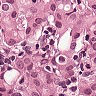

In [6]:
img = Image.open(full_filenames[0])
print(img.size)
img

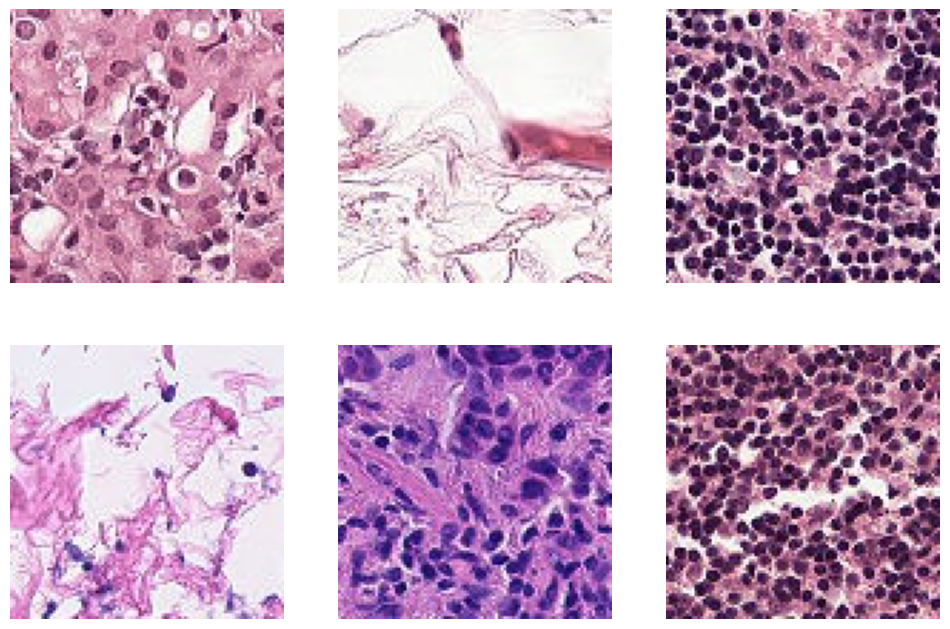

In [7]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
image_paths = [path for path in  full_filenames[:6]]

for i, ax in enumerate(axs.flat):
    image = Image.open(image_paths[i])
    ax.imshow(image)
    ax.axis('off')
    
plt.show()

# train-val-test split

In [9]:
train_labels = train_labels.sample(frac = 1, random_state = 42)

train, test = train_test_split(
    train_labels,
    test_size = int(len(train_labels)*0.25),
    random_state = 42,
    stratify = train_labels['label']
)

train, val = train_test_split(
    train,
    test_size = int(len(train_labels)*0.25),
    random_state = 42,
    stratify = train['label']
)

print(len(train), len(val), len(test))

110013 55006 55006


In [9]:
train['label'].value_counts(),\
val['label'].value_counts(),\
test['label'].value_counts()

(label
 0    65454
 1    44559
 Name: count, dtype: int64,
 label
 0    32727
 1    22279
 Name: count, dtype: int64,
 label
 0    32727
 1    22279
 Name: count, dtype: int64)

# Dataset

In [10]:
torch.manual_seed(42)

class CancerDatset(Dataset):

    def __init__(self, id_label_df, mode):
        
        if mode == 'train':
            self.transform = transforms.Compose([
                transforms.RandomHorizontalFlip(0.5),
                transforms.RandomVerticalFlip(0.5),
                transforms.RandomRotation(45),
                transforms.RandomResizedCrop(96, scale = (0.8, 1.0), ratio = (1.0, 1.0)),
                transforms.ToTensor()
            ])
        
        else:
            self.transform = transforms.Compose([
                transforms.ToTensor()
            ])
        # организовываем путь ко всем файлам текущего mode
        self.full_filenames = ['train/' + path + '.tif' for path in id_label_df['id']]
        self.labels = [label for label in id_label_df['label']]
        
    def __len__(self):
        return len(self.full_filenames)
        
    def __getitem__(self, index):
            
        image = Image.open(self.full_filenames[index])
        image = self.transform(image)

        return image, self.labels[index]
        

# Пробуем
dataset_try = CancerDatset(train, 'train')
dataset_try[0][0].shape

torch.Size([3, 96, 96])

In [11]:
train.head()

,id,label
139713,6c19125bf7c949a53e0018effa982c83227a1abe,1
189692,aebc4f502ecc3bae19254578457e319a52ef17a6,1
25187,a636df46979b2fd8e1474a3313b7b01a23161a11,0
122553,331d54ec4561fa6f521bc294c9e7f1fa9162234a,0
153860,65b1745d289702afddbb7e3b9ca3319cff148041,1


# Dataloader

In [11]:
train_dataloader = DataLoader(
    dataset = CancerDatset(train, 'train'),
    batch_size = 2048,
    shuffle = False # уже перемешал при train_test_split
)

val_dataloader = DataLoader(
    dataset = CancerDatset(val, 'val'),
    batch_size = 2048,
    shuffle = False # уже перемешал при train_test_split
)

# проверка
for x, y in train_dataloader:
    print(x.shape)
    print(y.shape)
    break

torch.Size([2048, 3, 96, 96])
torch.Size([2048])


# Model

## Функция помощник (подсчет размера выходного тензора)

In [12]:
def findConv2dOutShape(H_in,W_in,conv,pool=2):

    kernel_size=conv.kernel_size
    stride=conv.stride
    padding=conv.padding
    dilation=conv.dilation

    H_out=np.floor((H_in+2*padding[0]-
    dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    W_out=np.floor((W_in+2*padding[1]-
    dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)
    if pool:
        H_out/=pool
        W_out/=pool
    return int(H_out),int(W_out)


conv1d = nn.Conv2d(3,8,kernel_size = 3)
findConv2dOutShape(96, 96, conv1d)

(47, 47)

In [14]:
class Net(nn.Module):

    def __init__(self, matrix_size, channels_increase):
        super(Net, self).__init__()

        batch_size, channels_in , H_in, W_in = matrix_size

        self.conv1 = nn.Conv2d(
            in_channels = channels_in,
            out_channels = channels_in*channels_increase,
            kernel_size = 3)
        h, w = findConv2dOutShape(H_in, W_in, self.conv1)
        self.conv2 = nn.Conv2d(
            in_channels = channels_in*channels_increase,
            out_channels = channels_in*(channels_increase**2),
            kernel_size = 3)
        h, w = findConv2dOutShape(h, w, self.conv2)
        self.conv3 = nn.Conv2d(
            in_channels = channels_in*(channels_increase**2),
            out_channels = channels_in*(channels_increase**3),
            kernel_size = 3)
        h, w = findConv2dOutShape(h, w, self.conv3)
        self.conv4 = nn.Conv2d(
            in_channels = channels_in*(channels_increase**3),
            out_channels = channels_in*(channels_increase**4),
            kernel_size = 3)
        h, w = findConv2dOutShape(h, w, self.conv4)
        self.conv5 = nn.Conv2d(
            in_channels = channels_in*(channels_increase**4),
            out_channels = channels_in*(channels_increase**5),
            kernel_size = 3)
        h, w = findConv2dOutShape(h, w, self.conv5)

        self.num_neuros_to_linear = h*w*(channels_in*(channels_increase**5))

        self.dropout = nn.Dropout(0.4)

        self.linear_1 = nn.Linear(self.num_neuros_to_linear, 500)
        self.linear_2 = nn.Linear(500, 1)
    
    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        #######
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        #######
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        #######
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)
        #######
        x = F.relu(self.conv5(x))
        x = F.max_pool2d(x, 2, 2)
        #######
        x = x.view(-1, self.num_neuros_to_linear)
        #######
        x = self.linear_1(x)
        x = self.dropout(x)
        x = self.linear_2(x)

        return F.sigmoid(x)

# Проверка модели

In [15]:
in_channels = 3


conv2d_1 = nn.Conv2d(
    in_channels = 3,
    out_channels = in_channels*2,
    kernel_size = 3
)

conv2d_1_out = conv2d_1(x)
conv2d_1_out.shape

torch.Size([2048, 6, 94, 94])

In [16]:
max_pool_1_out = F.max_pool2d(conv2d_1_out, 2, 2)
max_pool_1_out.shape

torch.Size([2048, 6, 47, 47])

In [17]:
conv2d_2 = nn.Conv2d(
    in_channels = in_channels*2,
    out_channels = in_channels*4,
    kernel_size = 3
)

conv2d_2_out = conv2d_2(max_pool_1_out)
print(conv2d_2_out.shape)

max_pool_2_out = F.max_pool2d(conv2d_2_out, 2, 2)
max_pool_2_out.shape

torch.Size([2048, 12, 45, 45])


torch.Size([2048, 12, 22, 22])

In [18]:
conv2d_3 = nn.Conv2d(
    in_channels = in_channels*4,
    out_channels = in_channels*8,
    kernel_size = 3
)

conv2d_3_out = conv2d_3(max_pool_2_out)
print(conv2d_3_out.shape)

max_pool_3_out = F.max_pool2d(conv2d_3_out, 2, 2)
max_pool_3_out.shape

torch.Size([2048, 24, 20, 20])


torch.Size([2048, 24, 10, 10])

In [19]:
conv2d_4 = nn.Conv2d(
    in_channels = in_channels*8,
    out_channels = in_channels*16,
    kernel_size = 3
)

conv2d_4_out = conv2d_4(max_pool_3_out)
print(conv2d_4_out.shape)

max_pool_4_out = F.max_pool2d(conv2d_4_out, 2, 2)
max_pool_4_out.shape

torch.Size([2048, 48, 8, 8])


torch.Size([2048, 48, 4, 4])

In [20]:
conv2d_5 = nn.Conv2d(
    in_channels = in_channels*16,
    out_channels = in_channels*32,
    kernel_size = 3
)

conv2d_5_out = conv2d_5(max_pool_4_out)
print(conv2d_5_out.shape)

max_pool_5_out = F.max_pool2d(conv2d_5_out, 2, 2)
max_pool_5_out.shape

torch.Size([2048, 96, 2, 2])


torch.Size([2048, 96, 1, 1])

In [21]:
x_view = max_pool_5_out.view(-1, 96*1*1)
x_view.shape

torch.Size([2048, 96])

In [22]:
linear_1 = nn.Linear(96, 100)
linear_1_out = linear_1(x_view)
linear_1_out.shape

torch.Size([2048, 100])

In [23]:
linear_2 = nn.Linear(100, 1)
probas = F.sigmoid(linear_2(linear_1_out))
probas.shape

torch.Size([2048, 1])

# Доп. функции

In [15]:
def batch_accuracy(probas, real_labels):
    predict_labels = torch.where(probas > 0.5, torch.tensor(1), torch.tensor(0)).reshape(1,-1)
    num_correct_predict = torch.sum((real_labels == predict_labels))
    accuracy = num_correct_predict / len(real_labels)
    return accuracy.item()

In [16]:
def loss_with_l1_or_l2_regulizer(
        
        model,
        type, # Здесь могут быть 3 вида : 'l1', 'l2', 'l1_l2' 
        l_lambda, # 0.001
        loss_by_fn):
    
    if type == 'l2':
        l_norm = sum(p.pow(2.0).sum() for p in model.parameters())

    if type == 'l1':
        l_norm = sum(p.abs().sum() for p in model.parameters())

    if type == 'l1_l2':
        l_norm = sum((p.abs() + p.pow(2.0)).sum() for p in model.parameters())
    
    loss_plus_reg = loss_by_fn + l_lambda * l_norm
    return loss_plus_reg



def create_folder(name):
    import os
    os.mkdir(name)

"\ndef save_better_weights(model):\n    torch.save(model.state_dict(), f'{name_model_folder}/model_weights_on_{epoch}_epoch')"

# Training loop

In [17]:
def training_loop(
        # папка сохранения
        name_model_folder,


        # основные настройки
        epoches,
        model,
        optimizer,

        # контроль скорости
        scheduler_append,
        scheduler,

        loss_fn,
        train_dataloader,
        val_dataloader,

        # regulizer
        regulizer_append,
        reg_type,
        
        # stop settings
        stop_mode,
        each__X__epoch,
        min_delta,
        patience,

        # verbose
        verbose_epoch
        ):
    
    
    create_folder(name_model_folder)
    
    loss_train_list = []
    loss_val_list = []
    accuracy_train_list = []
    accuracy_val_list = []
    len_train_dataset = len(train_dataloader.dataset)
    len_val_dataset = len(val_dataloader.dataset)
    best_loss = float('inf')
    patience_beginner = patience

    model = model.to(device)

    for epoch in range(1, epoches+1):
            
            start_time = time.time()

            loss_train = 0.0
            loss_val = 0.0
            correct_train_predict = 0
            correct_val_predict = 0

            for features, labels in train_dataloader:
                
                model.train()
                features = features.to(device)
                labels = labels.to(device)
                outputs = model(features)

                # Тренировочный потери
                loss = loss_fn(outputs, labels.reshape(-1,1).float())
                
                if regulizer_append:
                        loss = loss_with_l1_or_l2_regulizer(
                                model = model,
                                type = reg_type,
                                l_lambda = 0.001,
                                loss_by_fn = loss
                                )
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                loss_train += loss.item()

                predict_labels = torch.where(outputs > 0.5, torch.tensor(1), torch.tensor(0)).reshape(1,-1)
                num_correct_predict_on_batch = torch.sum((labels == predict_labels)).item()
                correct_train_predict += num_correct_predict_on_batch

            mean_epoch_loss_train = loss_train/len(train_dataloader)
            loss_train_list.append(mean_epoch_loss_train)
            ######## Расчет метрики на тренировочном наборе #####
            accuracy_train_epoch = correct_train_predict / len_train_dataset
            accuracy_train_list.append(accuracy_train_epoch)
            #####################################################
            # Проверочный этап
            model.eval()
            with torch.no_grad():
                for features, labels in val_dataloader:
                        features = features.to(device)
                        labels = labels.to(device)
                        outputs = model(features)
                        loss_on_val = loss_fn(outputs, labels.reshape(-1,1).float())
                        loss_val += loss_on_val.item()

                        predict_labels = torch.where(outputs > 0.5, torch.tensor(1), torch.tensor(0)).reshape(1,-1)
                        num_correct_predict_on_batch = torch.sum((labels == predict_labels)).item()
                        correct_val_predict += num_correct_predict_on_batch

                mean_epoch_loss_val = loss_val / len(val_dataloader)
                loss_val_list.append(mean_epoch_loss_val)

                ######## Расчет метрики на валидационном наборе #####
                accuracy_val_epoch = correct_val_predict / len_val_dataset
                accuracy_val_list.append(accuracy_val_epoch)
                ######################################################


            # EARLY STOPPING #######################################
            if stop_mode:
                if epoch % each__X__epoch == 0:
                        current_loss = mean_epoch_loss_train
                        if current_loss < best_loss - min_delta:
                                best_loss = current_loss
                                patience = patience_beginner
                        else:
                                patience -= 1
                                if patience == 0:
                                        print(f"Ранняя тренировочная остановка на {epoch} эпохе")
                                        break
            ##############################################################
            # Сохранение состояний модели
            if mean_epoch_loss_val < best_loss:
                    best_loss = mean_epoch_loss_val
                    torch.save(model.state_dict(), f'{name_model_folder}/model_weights_{epoch}_epoch.pth')
            # Контроль скорости обучения
            if scheduler_append:
                scheduler.step(mean_epoch_loss_train)
            ##############################################################
            end_time = time.time()
            epoch_time = end_time - start_time
            расчетное_время_выполнения_цикла = (epoch_time*epoches) / 60
            ############ VERBOSE #########################################
            if epoch ==1:
                   print('Расчетное время выполнения всего цикла {:.3f} минут'.format(расчетное_время_выполнения_цикла))            
            if epoch == 1 or epoch % verbose_epoch == 0:
                print(
                        'Epoch {:5}/{:5} || time: {:.3f} || train loss: {:.3f} || val_loss: {:.3f} || train accuracy: {:.3f} || val accuracy: {:.3f}'
                        .format(epoch,
                                epoches,
                                epoch_time,
                                mean_epoch_loss_train,
                                mean_epoch_loss_val,
                                accuracy_train_epoch,
                                accuracy_val_epoch
                                )     
                      )
    ###### PLOTTING #############################################################################
    sns.lineplot(x = np.arange(1, epoch+1),
                 y = loss_train_list,
                 label = 'train')
    sns.lineplot(x = np.arange(1, epoch+1),
                 y = loss_val_list,
                 label = 'val')
    plt.title('Потери от эпох')
    plt.xlabel('эпохи')
    plt.ylabel('loss')
    plt.legend()
    plt.grid()
    plt.show()

    sns.lineplot(x = np.arange(1, epoch+1),
                 y = accuracy_train_list,
                 label = 'train')
    sns.lineplot(x = np.arange(1, epoch+1),
                 y = accuracy_val_list,
                 label = 'val')
    
    plt.xlabel('эпохи')
    plt.ylabel('accuracy')
    plt.title('accuracy on train: {}   lr: {}'.format(epoches,
                                                      optimizer.param_groups[0]['lr']))
    plt.legend()
    plt.grid()
    plt.show()

# Модель 1 

Расчетное время выполнения всего цикла 19791.985 минут
Epoch     1/10000 || time: 118.752 || train loss: 0.660 || val_loss: 0.567 || train accuracy: 0.607 || val accuracy: 0.738
Epoch     2/10000 || time: 119.309 || train loss: 0.509 || val_loss: 0.497 || train accuracy: 0.762 || val accuracy: 0.772
Epoch     3/10000 || time: 121.332 || train loss: 0.470 || val_loss: 0.517 || train accuracy: 0.785 || val accuracy: 0.762
Epoch     4/10000 || time: 117.996 || train loss: 0.464 || val_loss: 0.495 || train accuracy: 0.789 || val accuracy: 0.774
Epoch     5/10000 || time: 119.430 || train loss: 0.455 || val_loss: 0.490 || train accuracy: 0.793 || val accuracy: 0.777
Epoch     6/10000 || time: 118.506 || train loss: 0.456 || val_loss: 0.464 || train accuracy: 0.792 || val accuracy: 0.791
Epoch     7/10000 || time: 117.955 || train loss: 0.453 || val_loss: 0.567 || train accuracy: 0.794 || val accuracy: 0.734
Epoch     8/10000 || time: 118.406 || train loss: 0.442 || val_loss: 0.441 || train 

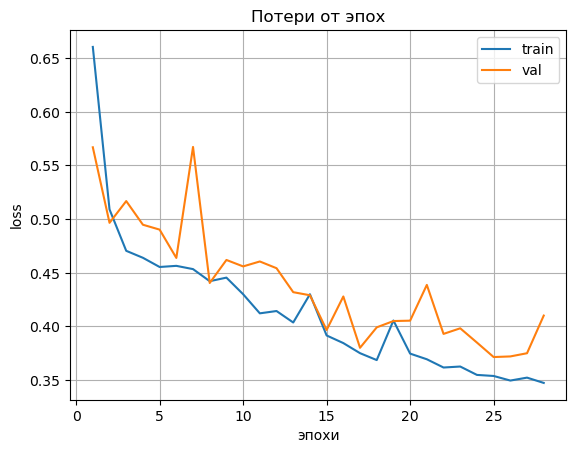

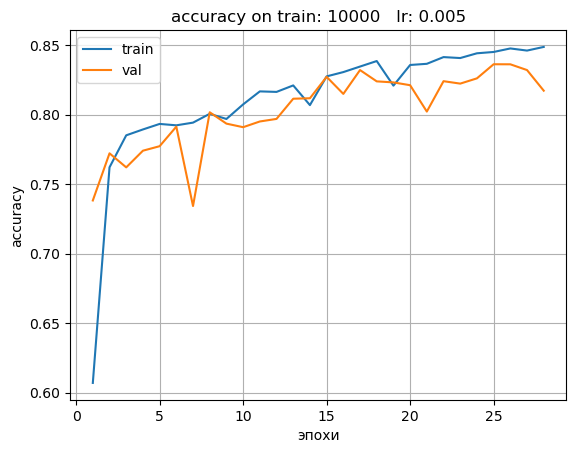

In [30]:
train_dataloader = DataLoader(
    dataset = CancerDatset(train, 'train'),
    batch_size = 2048,
    shuffle = False # уже перемешал при train_test_split ------------------------------------
)

val_dataloader = DataLoader(
    dataset = CancerDatset(val, 'val'),
    batch_size = 2048,
    shuffle = False # уже перемешал при train_test_split
)

model = Net(
    (train_dataloader.batch_size, 3, 96, 96),
    channels_increase = 2
    )

optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)
loss_fn = nn.BCELoss()
scheduler = ReduceLROnPlateau(
    optimizer,
    mode = 'min',
    factor = 0.5,
    patience = 100,
    verbose = False,
    threshold = 0.0001,
    min_lr = 0.000001)

training_loop(
    name_model_folder = 'madel_1',
    epoches = 10000,
    model = model,
    optimizer = optimizer,
    loss_fn = loss_fn,
    scheduler_append = False,
    scheduler = scheduler,
    regulizer_append = False,
    reg_type = 'l1',
    train_dataloader = train_dataloader,
    val_dataloader = val_dataloader,
    stop_mode = True,
    each__X__epoch = 10,
    stop_diff_value = 0.0001,
    verbose_epoch = 1
)

# Модель 2 

In [ ]:
train_dataloader = DataLoader(
    dataset = CancerDatset(train, 'train'),
    batch_size = 2048,
    shuffle = False # уже перемешал при train_test_split
)

val_dataloader = DataLoader(
    dataset = CancerDatset(val, 'val'),
    batch_size = 2048,
    shuffle = False # уже перемешал при train_test_split
)

model = Net(
    (train_dataloader.batch_size, 3, 96, 96),
    channels_increase = 2
    )

optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)
loss_fn = nn.BCELoss()
scheduler = ReduceLROnPlateau(
    optimizer,
    mode = 'min',
    factor = 0.5,
    patience = 100,
    verbose = False,
    threshold = 0.0001,
    min_lr = 0.000001)


training_loop(
    name_model_folder = 'model_2',
    epoches = 10000,
    model = model,
    optimizer = optimizer,
    scheduler_append = True,
    scheduler = scheduler,
    loss_fn = loss_fn,
    train_dataloader = train_dataloader,
    val_dataloader = val_dataloader,
    regulizer_append = False,
    reg_type = 'l1',
    stop_mode = True,
    each__X__epoch = 50,
    min_delta = 0.001,
    patience = 20,
    verbose_epoch = 50
)

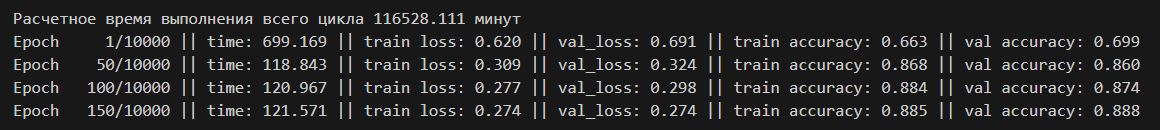